In [1]:
import gensim
import gensim.downloader as api

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set()

In [2]:
matplotlib.rcParams['figure.figsize'] = (15.0, 7.8)  # (30.0, 15.8)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

def save_fig(filename):
    new_filename = 'plots/' + filename.replace(' ', '-').lower()
    plt.savefig(new_filename, bbox_inches = 'tight')

In [3]:
GLOVE = 'GloVe'
CONCEPT_NET = 'Conceptnet Numberbatch'
WORD2VEC = 'Word2Vec'
FAST_TEXT = 'FastText'

word_embed_name_to_file = {
    GLOVE: 'glove-wiki-gigaword-300',
    CONCEPT_NET: 'conceptnet-numberbatch-17-06-300',
    WORD2VEC: 'word2vec-google-news-300',
    FAST_TEXT: 'fasttext-wiki-news-subwords-300'
}

# Data

All the generic terms that appear for most classes have been ignored for now since it would result in a plot with a lot of data points on top of each other.

In [4]:
reuters = ['person', 'organization', 'location', 'miscellaneous']

politics = ['politician', 'political party', 'election',
           # 'country', 'location', 'event', 'miscellaneous', 'organization', 'person'
           ]

nat_science = ['scientist', 'university',
               'discipline', 'enzyme', 'protein',
               'chemical compound', 'chemical element',
               'astronomical object', 'academic journal', 'theory',
              # 'person', 'country', 'event', 'award', 'miscellaneous', 'organization', 'location'
              ]

music = ['music genre', 'song', 'band', 'album', 'musical artist', 'musical instrument',
         #'organization', 'person', 'miscellaneous', 'award', 'event', 'country', 'location',
        ]


lit = ['book', 'writer', 'poem', 'event', 'magazine',
       #'award', 'person', 'location', 'organization', 'country', 'miscellaneous',
      ]

ai = ['field', 'task', 'product', 'algorithm', 'researcher', 'metrics', 'university',
      #'country', 'person', 'organization', 'location', 'miscellaneous'
     ]

domains = [reuters, politics, nat_science, music, lit, ai]


labels = {
    'Politics': politics,
    'Natural Science': nat_science,
    'Music': music,
    'Literature': lit,
    'AI': ai,
    #'reuters': reuters,
}

label_nums = {
    'Politics': 0,
    'Natural Science': 1,
    'Music': 2,
    'Literature': 3,
    'AI': 4,
    'Reuters': 5,
}

In [5]:
def transform_data(word_embeddings, embed):
    words_arr, X, Y = [], [], []
    prefix = '/c/en/' if embed == CONCEPT_NET else ''

    for label, words in labels.items():
        for word in words:
            Y.append(label_nums[label])
            words_arr.append(word)
            clean_word = prefix + word.replace(' ', '_')

            # Strategy: If full word, i.e. 'political_party' is present, use that.
            # Otherwise take average of 'political' and 'party'
            if clean_word in word_embeddings:
                word_vec = word_embeddings[clean_word]                  
            else:
                word_vec = np.mean([word_embeddings[subword] for subword in word.split()], axis=0)

            X.append(word_vec)

    X = np.array(X)
    Y = np.array(Y)
    return X, Y, words_arr

# Plot code

In [6]:
def plot_pca_variance_explained(pca, embed):
    n = len(pca.explained_variance_ratio_)
    xs = np.arange(1, n + 1)
    ys = np.cumsum(pca.explained_variance_ratio_)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, gridspec_kw={'wspace': 0.05})
    fig.suptitle(f"Total variance explained by number of PCs ({embed})")
    ax1.plot(xs, ys)
    ax1.set(xlabel="$D$ - Number of PCs (linear scale)",
            ylabel="Total variance explained")

    ax2.plot(xs, ys)
    ax2.set(xlabel="$D$ - Number of PCs (log$_2$-scale)", xticks=xs)
    ax2.set_xscale('log', base=2)

    save_fig(f"var-pca/{embed}-var.pdf")
    plt.show()

In [7]:
def plot_latent_pca(X, Y, embed, words_arr, pca):
    '''
    Sample plot to visualize the latent space if x1, x2 are the 1st and 2nd
    dimensions of dimensionality reduced data, with labels y.
    '''
    pc1_pct, pc2_pct = pca.explained_variance_ratio_[:2] * 100
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(f'Latent Space Visualization for PCA ({embed})')
    ax.set_xlabel(f'PC1 ({pc1_pct:.2f} %)')
    ax.set_ylabel(f'PC2 ({pc2_pct:.2f} %)')
    
    scatter = ax.scatter(X[:, 0], X[:, 1], c=Y, edgecolor='none',
                cmap=cm.get_cmap('Paired', 5), s=500, alpha=0.5)
    
    lines = scatter.legend_elements()[0]
    legend1 = ax.legend(lines, list(labels.keys()), title="Classes", loc="upper left")
    ax.add_artist(legend1)
    
    for i, (x, y) in enumerate(X[:, :2]):
        ax.text(x, y, words_arr[i])

    save_fig(f'pca-{embed}.pdf')
    plt.show()

In [8]:
def plot_latent_tsne(X, Y, embed, words_arr):
    '''
    Sample plot to visualize the latent space if x1, x2 are the 1st and 2nd
    dimensions of dimensionality reduced data, with labels y.
    '''
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(f'Latent Space Visualization for t-SNE ({embed})')
    ax.set_xlabel(f'Axis 1')
    ax.set_ylabel(f'Axis 2')
    
    vals = TSNE(n_components=2).fit_transform(X)
    scatter = ax.scatter(vals[:, 0], vals[:, 1], c=Y, edgecolor='none',
                cmap=cm.get_cmap('Paired', 5), s=500, alpha=0.5)
    
    lines = scatter.legend_elements()[0]
    legend1 = ax.legend(lines, list(labels.keys()), title="Classes", loc="upper left")
    ax.add_artist(legend1)
    
    for i, (x, y) in enumerate(vals[:, :2]):
        ax.text(x, y, words_arr[i])

    save_fig(f'tsne-{embed}.pdf')
    plt.show()

# Plotting all word embeds

In [9]:
def load_and_plot(embed, verbose=True):
    print(f'Loading {embed} embeddings...')
    word_embeddings = api.load(word_embed_name_to_file[embed])
    word_matrix = np.array(word_embeddings.wv.syn0)
    X, Y, words_arr = transform_data(word_embeddings, embed)
    
    print('Fitting PCA...')
    pca = PCA()
    pca.fit(word_matrix)
    
    print('Plotting...')
    plot_pca_variance_explained(pca, embed)
    plot_latent_pca(pca.transform(X), Y, embed, words_arr, pca)
    plot_latent_tsne(X, Y, embed, words_arr)
    
    del word_embeddings
    del word_matrix

Loading Conceptnet Numberbatch embeddings...


<ipython-input-9-88dbcb974258>:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  word_matrix = np.array(word_embeddings.wv.syn0)
<ipython-input-9-88dbcb974258>:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  word_matrix = np.array(word_embeddings.wv.syn0)


Fitting PCA...
Plotting...


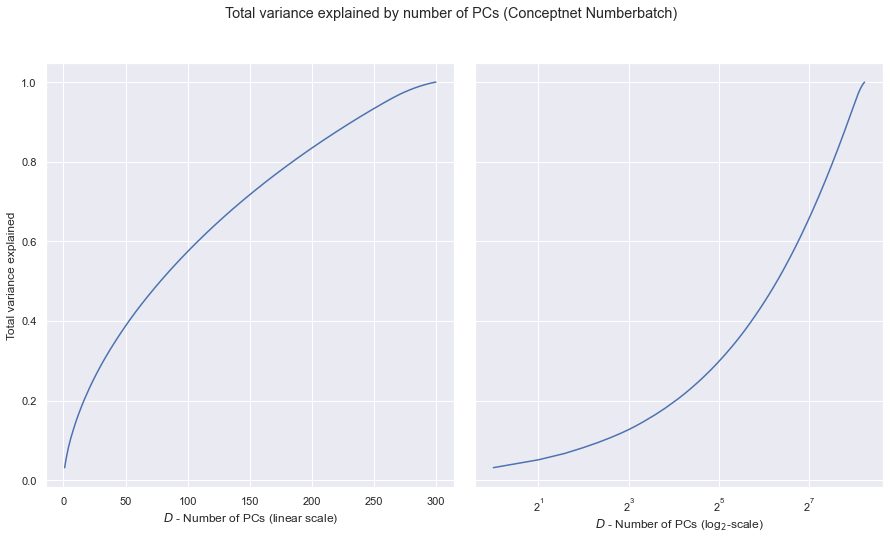

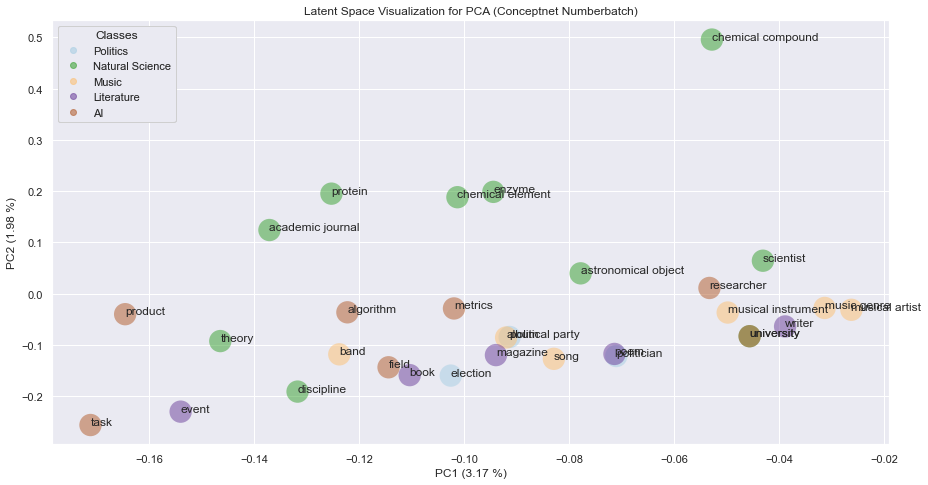

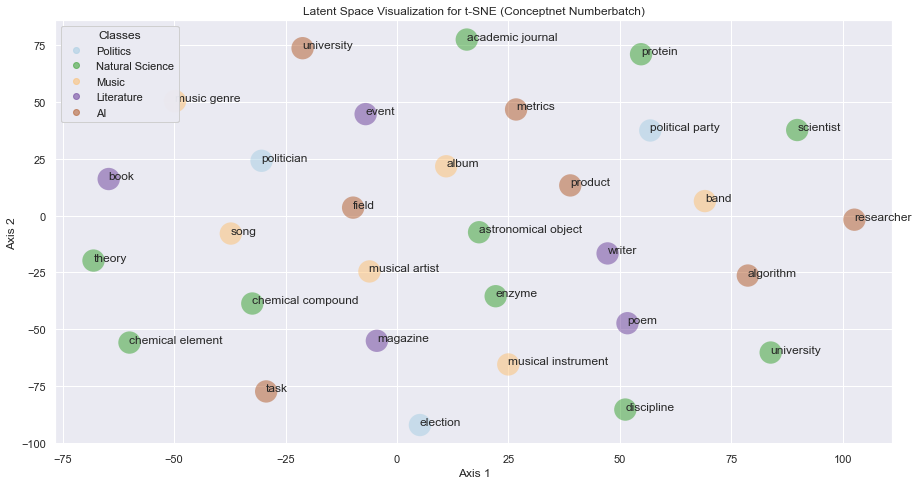

Loading GloVe embeddings...


<ipython-input-9-88dbcb974258>:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  word_matrix = np.array(word_embeddings.wv.syn0)
<ipython-input-9-88dbcb974258>:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  word_matrix = np.array(word_embeddings.wv.syn0)


Fitting PCA...
Plotting...


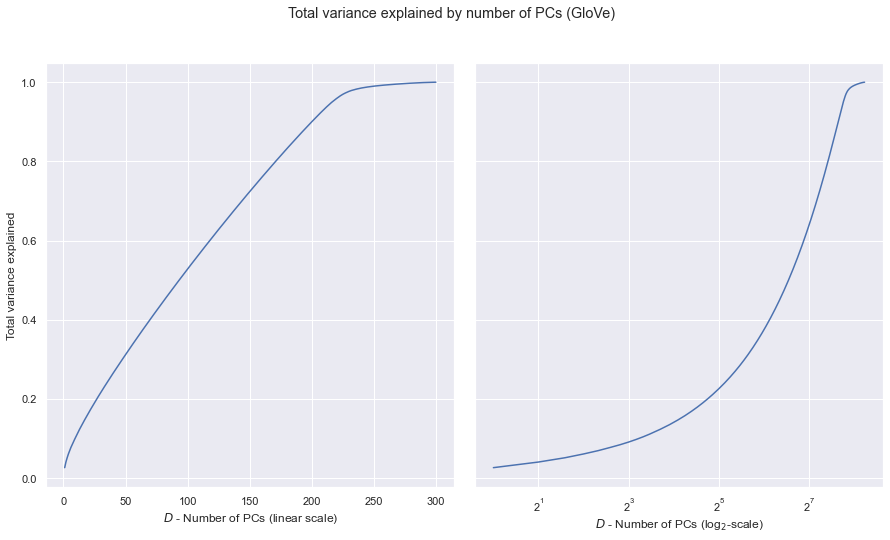

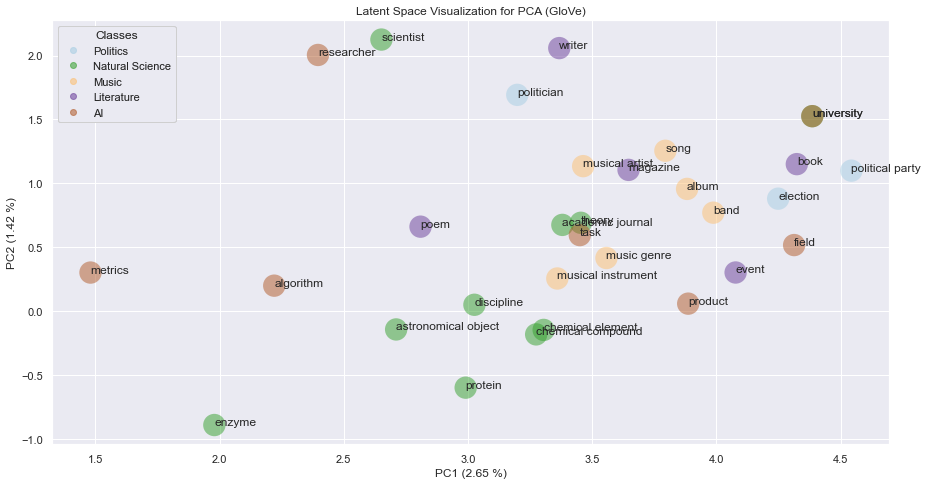

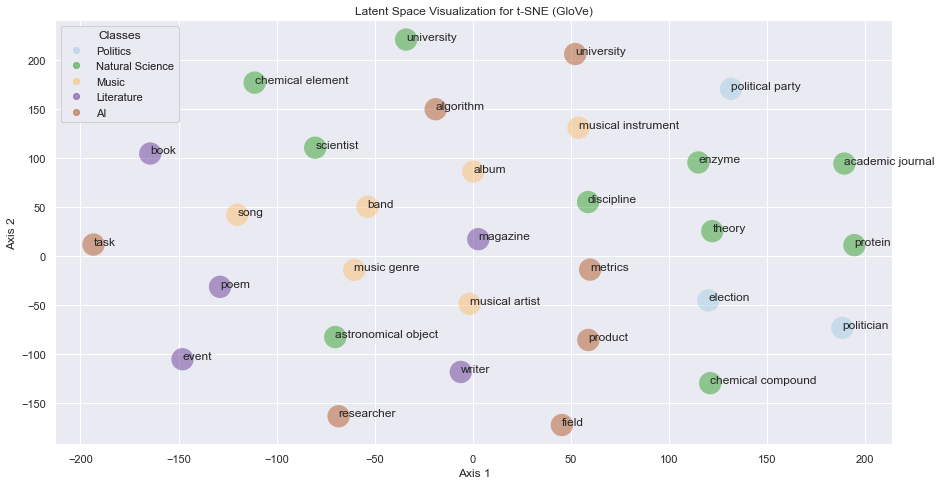

Loading FastText embeddings...


<ipython-input-9-88dbcb974258>:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  word_matrix = np.array(word_embeddings.wv.syn0)
<ipython-input-9-88dbcb974258>:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  word_matrix = np.array(word_embeddings.wv.syn0)


Fitting PCA...
Plotting...


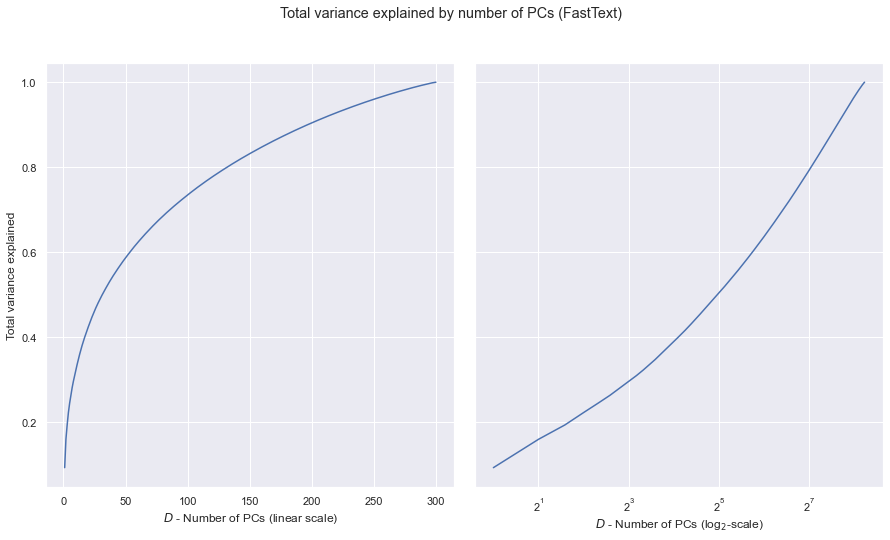

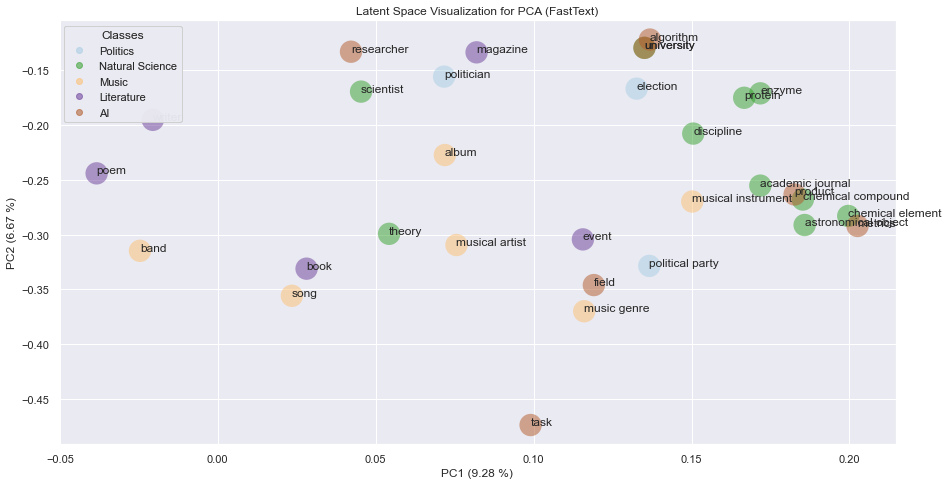

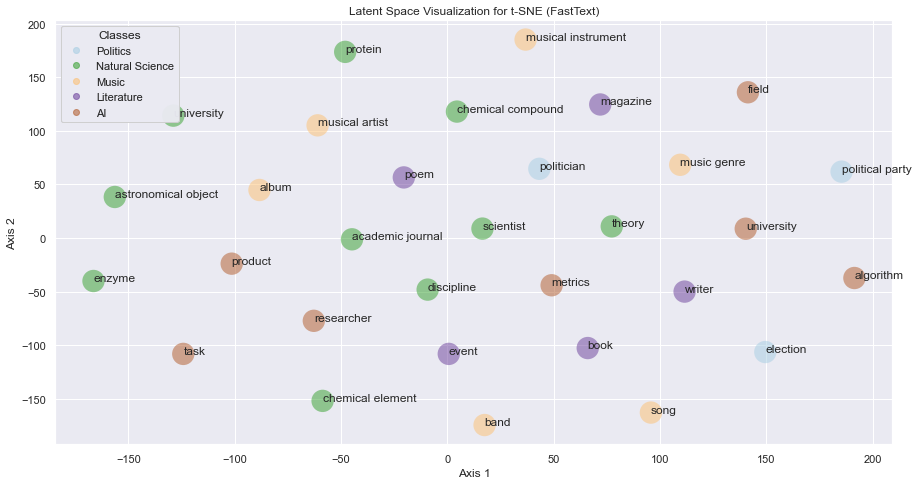

Loading Word2Vec embeddings...


<ipython-input-9-88dbcb974258>:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  word_matrix = np.array(word_embeddings.wv.syn0)
<ipython-input-9-88dbcb974258>:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  word_matrix = np.array(word_embeddings.wv.syn0)


Fitting PCA...
Plotting...


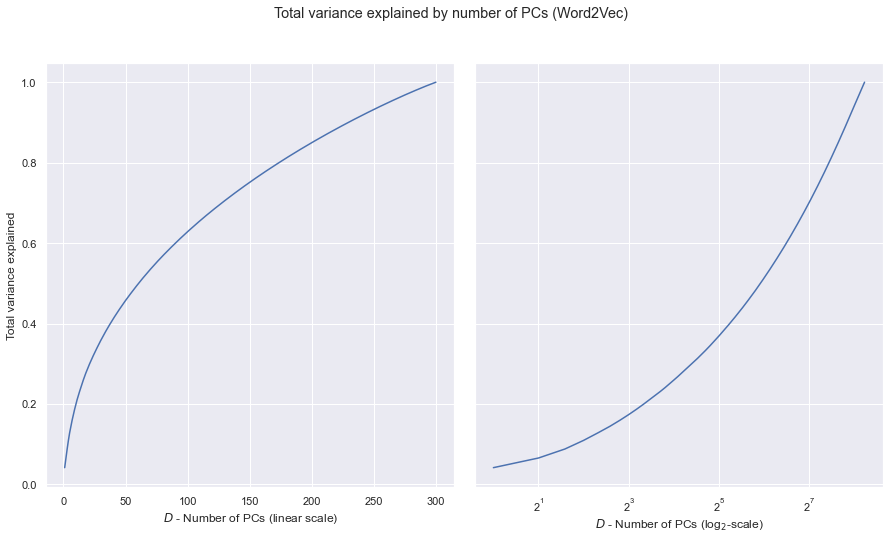

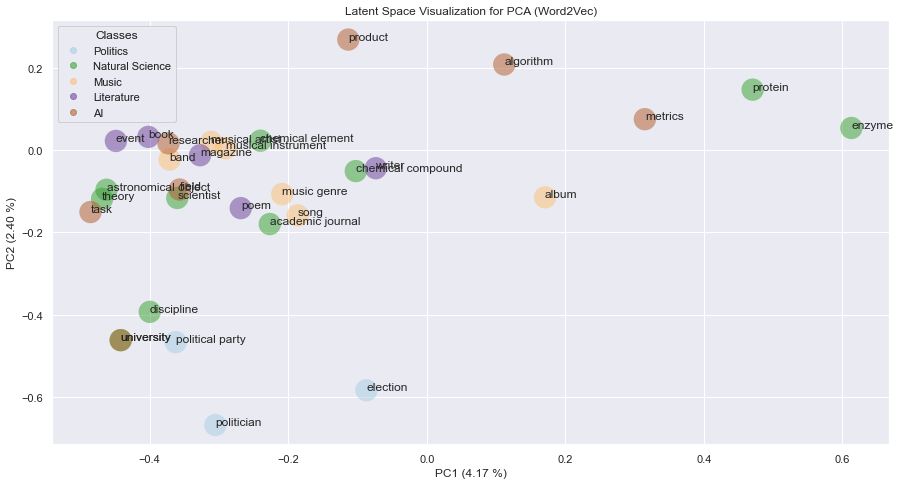

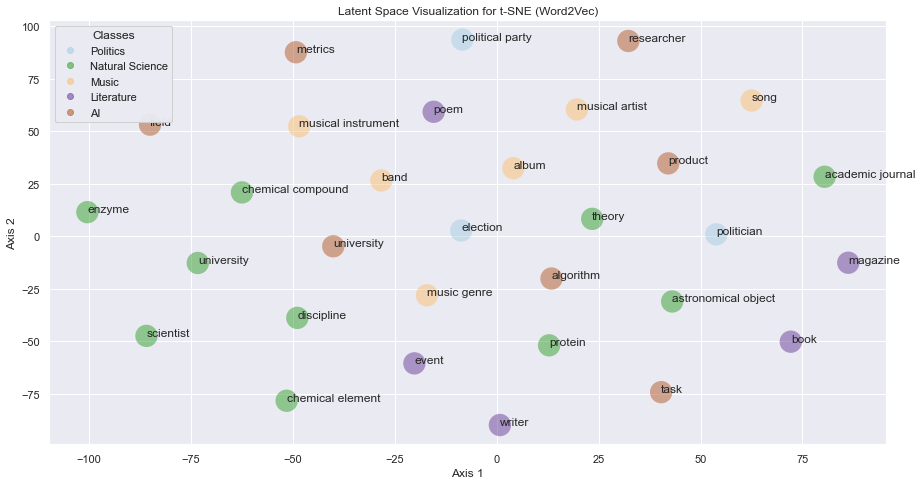

In [10]:
for embed in [CONCEPT_NET, GLOVE, FAST_TEXT, WORD2VEC]:
    load_and_plot(embed)